# Data-set generation

In this notebook, the strategies to generate data set are shown. The generated structures are then collected into `StructureStorage` and prepared for Training the interatomic potential.

In [1]:
%config IPCompleter.evaluation='unsafe'

In [2]:
from pyiron import Project
import numpy as np

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2024-03-28 13:16:19,387 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/menon/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


We start by creating a project

In [3]:
pr = Project('dataset_generation_1')

Pyiron also provides a structure storage, which is also imported

In [4]:
from pyiron_atomistics.atomistics.structure.structurestorage import StructureStorage

## Generating bulk structures

One of the strategies employed is to generate bulk structure of both Al and Li, in fcc, bcc, and hcp structures. These structures are then fully relaxed, and stored for ML fitting. Here, we will show the example of fcc Al.

In [5]:
Al = pr.create.structure.bulk('Al', cubic=True, a=4.04)

For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Now we have to relax this structure. Ideally, high convergence DFT calculations are needed. To generate the actual dataset, the software VASP was employed. Here we will simply use LAMMPS with an emperical potential to demonstrate the calculations. See the end of the notebook for an example of how to switch to DFT.

In [6]:
job = pr.create.job.Lammps('Al_bulk', delete_aborted_job=True)
job.structure = Al

Once the structure is assigned, an appropriate potential should also be chosen. This list of available for the structure containing Al can be found below.  This list originates from the NIST Interatomic Potential Database.

In [7]:
job.list_potentials()[0:10]

['AlLi-EAM',
 'AlLi-ACE',
 'AlLi-HDNNP',
 '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1',
 '1996--Farkas-D--Nb-Ti-Al--LAMMPS--ipr1',
 '1997--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1',
 '1999--Liu-X-Y--Al-Cu--LAMMPS--ipr1',
 '1999--Mishin-Y--Al--LAMMPS--ipr1',
 '2000--Landa-A--Al-Pb--LAMMPS--ipr1']

We choose a potential

In [8]:
job.potential = "AlLi-ACE"

Now relax the structure

In [9]:
job.calc_minimize(pressure=0)

And run the job

In [10]:
job.run()

The job Al_bulk was saved and received the ID: 3235


Another step done to collect structures for fitting is to run a EV curve . We can use the Murnaghan job from pyiron for this. First we set up a LAMMPS job again.

In [11]:
job = pr.create.job.Lammps('Al_bulk', delete_existing_job=True, delete_aborted_job=True)
job.structure = Al
job.potential = "AlLi-ACE"
job.calc_minimize()

Now we can create a Murnaghan Job

In [12]:
murn = job.create_job(pr.job_type.Murnaghan, 'murnaghan')

We can check the possible input options

In [13]:
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'mur..."
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume define...
4,axes,"(x, y, z)",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If...
6,allow_aborted,0,The number of child jobs that are allowed to a...


And run the job

In [14]:
murn.run()

The job murnaghan was saved and received the ID: 3235
The job murnaghan_0_9 was saved and received the ID: 3236
The job murnaghan_0_92 was saved and received the ID: 3237
The job murnaghan_0_94 was saved and received the ID: 3238
The job murnaghan_0_96 was saved and received the ID: 3239
The job murnaghan_0_98 was saved and received the ID: 3240
The job murnaghan_1_0 was saved and received the ID: 3241
The job murnaghan_1_02 was saved and received the ID: 3242
The job murnaghan_1_04 was saved and received the ID: 3243
The job murnaghan_1_06 was saved and received the ID: 3244
The job murnaghan_1_08 was saved and received the ID: 3245
The job murnaghan_1_1 was saved and received the ID: 3246


## <font style="font-family:roboto;color:#455e6c"> Scaling structures</font>  

Another approach used is scaling the structures. We start by creating a bulk fcc again.

In [15]:
Al = pr.create.structure.bulk('Al', cubic=True, a=4.04)

We now scale the structure such that minimum nearest neighbor distance is varied from 2 to 6.5 Å in 0.5 intervals. We will also create a `StructureStorage` which easily save these structures, and run calculations with them later.

In [16]:
store = StructureStorage()

We start by getting the minimum nearest neighbor distance

In [17]:
distances = Al.get_all_distances(mic=True).flatten()
min_distance = np.min(distances[np.nonzero(distances)])
min_distance

2.856711395993652

The range of distances needed, and convert them to fractions

In [18]:
d_arr = np.arange(2, 7, 0.5)
scale = d_arr/np.min(distances[np.nonzero(distances)])

Now for each scaling, create a structure and store it

In [19]:
for s in scale:
    struct = Al.copy()
    struct.apply_strain(s)
    store.add_structure(struct, identifier=f'fcc_nnscale_{s}')

Note that this procedure has to be repeated for other bulk structures of interest.

## <font style="font-family:roboto;color:#455e6c"> Structures from Materials Project</font>  

For binary AlLi structures, we queried them from materials project. This can be done with pyiron. Note that you have to provide a [Materials Project API key](https://next-gen.materialsproject.org/api#api-key) for this functionality.

In [20]:
api_key=''

We can query structures that lie on the convex hull

In [21]:
structures = pr.create.structure.materialsproject.search(['Al-Li'], is_stable=True, api_key=api_key)

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

We add these structures to the store

In [22]:
for structure in structures:
    store.add_structure(structure, identifier=structure.get_chemical_formula())

Note that you can also visualise the structures.

In [23]:
structures.get_structure(frame=3).plot3d()

NGLWidget()

We need to relax these structure, but also perfrom EV curves, and scaling of the nearest neighbor distance as before. This is skipped for now.

## <font style="font-family:roboto;color:#455e6c"> Adding strains</font>

A usual approach is to start with some prototypical structures and strain and shake them.  We can use the fcc Al we created earlier.

In [24]:
strains = np.linspace(-0.05, 0.05, 5)
strains

array([-0.05 , -0.025,  0.   ,  0.025,  0.05 ])

In [25]:
for eps in strains:
    store.add_structure(
        structure=Al.apply_strain(eps, return_box=True),
        identifier=f'fcc_{eps}'
    )

We can also add random displacements to atom positions using the `rattle` method

In [26]:
for eps in strains:
    structure = Al.apply_strain(eps, return_box=True)
    structure.rattle(0.05)
    print('Strain', eps, 'Volume', structure.get_volume(per_atom=True))
    store.add_structure(
        structure=structure,
        identifier=f'fcc_{eps}_rattle'
    )

Strain -0.05 Volume 14.133669118000002
Strain -0.025 Volume 15.279106254750001
Strain 0.0 Volume 16.484816
Strain 0.02500000000000001 Volume 17.75234380525
Strain 0.05 Volume 19.08323512199999


## <font style="font-family:roboto;color:#455e6c"> Random crystals</font>

`pyxtal` is a [program](https://pyxtal.readthedocs.io/en/latest/) to generate random structures of a given space group and stoichiometry.
It is useful for crystal structure prediction and also for generating training structures.
We will use it later again, so let's briefly look at how it works.

In [27]:
import structuretoolkit as stk
from pyiron_atomistics import ase_to_pyiron

`structuretoolkit` is a library for structure manipulation and analysis also developed by the pyiron team.  For compatibility with a wider range of codes it operates purely on ASE `Atoms` objects, so we need to convert structures explicitely here.  In the next release of `pyiron_atomistics` you will be able to call `pr.create.structure.pyxtal` directly for a more convenient wrapper.

We usually also use random crystals generated by sampling random space groups.  One would use more spacegroups and differently sized unit cells, but we'll keep it simple here.  Details can be found in [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.104103).

In [28]:
groups = [1, 194, 225]

In [29]:
for i, structure in enumerate(stk.build.pyxtal(
    group=groups,
    species=['Al'],
    num_ions=[4],
    tm='metallic'
)):
    store.add_structure(
        structure=structure['atoms'],
        identifier=f'random_{i}'
    )

Spacegroups:   0%|          | 0/3 [00:00<?, ?it/s]

We can now collected a number of structures in the store.

In [30]:
store.number_of_structures

27

The next step is to calculate the energies and forces

In [31]:
for i, structure in enumerate(store.iter_structures()):
    # pyiron has some opinions of what is a proper "job name" for technical reasons, but
    # you can always use this function to translate your favorite one into a "proper" one
    name = pr.create.job_name(store['identifier', i])
    job = pr.create.job.Lammps(name)
    job.potential = "AlLi-ACE"
    job.structure = structure
    job.calc_static()
    job.run()

The job fcc_nnscale_0d7001057239470768 was saved and received the ID: 3247
The job fcc_nnscale_0d875132154933846 was saved and received the ID: 3248
The job fcc_nnscale_1d0501585859206153 was saved and received the ID: 3249
The job fcc_nnscale_1d2251850169073843 was saved and received the ID: 3250
The job fcc_nnscale_1d4002114478941536 was saved and received the ID: 3251
The job fcc_nnscale_1d5752378788809227 was saved and received the ID: 3252
The job fcc_nnscale_1d750264309867692 was saved and received the ID: 3253
The job fcc_nnscale_1d925290740854461 was saved and received the ID: 3254
The job fcc_nnscale_2d1003171718412306 was saved and received the ID: 3255
The job fcc_nnscale_2d2753436028279994 was saved and received the ID: 3256
The job Al2Li4 was saved and received the ID: 3257
The job Al2Li3 was saved and received the ID: 3258
The job Al4Li9 was saved and received the ID: 3259
The job Al2Li2 was saved and received the ID: 3260
The job fcc_m0d05 was saved and received the ID: 

Once our reference calculations are finished, we can collect the results in a container for convenience.

In [32]:
train = pr.create.job.TrainingContainer("AlLi")

We include all the jobs we did so far in the TrainingContainer

In [33]:
for job in pr.iter_jobs(hamilton='Lammps', status='finished'):
    for i in range(job.number_of_structures):
        train.include_job(job, iteration_step=i)

  0%|          | 0/38 [00:00<?, ?it/s]

"Running" the container simply saves it to disk and to our database.  It can also precompute
nearest neighbor information.

In [34]:
train.run()

The job AlLi was saved and received the ID: 3274


Besides keeping everything in one place, the `TrainingContainer` also defines a number of plotting functions.

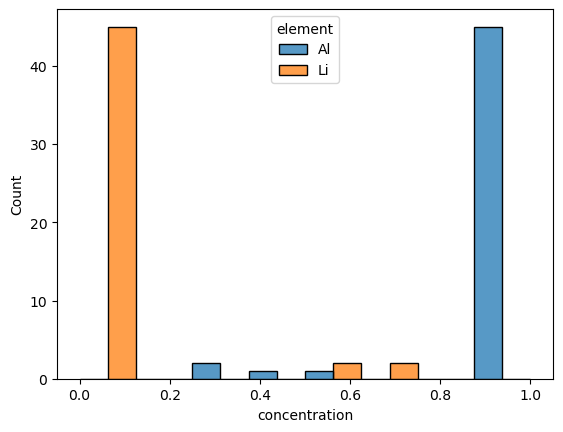

In [41]:
df = train.plot.concentration()

In [37]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Energy [eV/atom]')

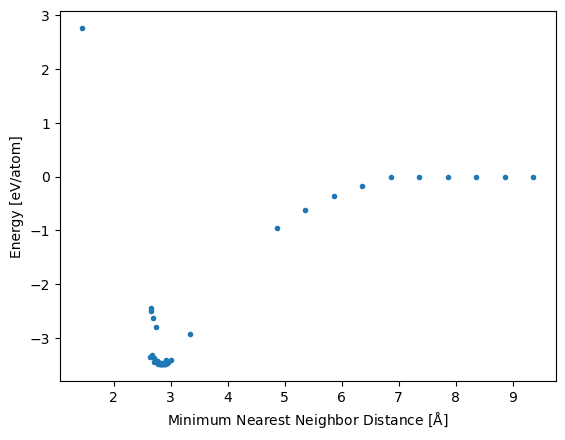

In [38]:
train.plot.energy_distance()
plt.xlabel(r'Minimum Nearest Neighbor Distance [$\mathrm{\AA}$]')
plt.ylabel('Energy [eV/atom]')

For fitting potentials within pyiron you can use the container as is, but if you have external tools, you can
export the data into a table.

In [42]:
df = train.to_pandas()

In [43]:
df

,name,atoms,energy,forces,stress,number_of_atoms
0,murnaghan_0_9,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9502885569035455, 1.9502885569035457], index=1), Atom('Al', [1.9502885569033719, 1.1942073193127126e-16, 1.9502885569035457], index=2), At...",-13.726807,"[[2.7755575615628894e-16, 2.4507447286825596e-11, 2.45097377488304e-11], [-1.6653345369377296e-16, -2.4507149131228194e-11, -2.4509806169592397e-11], [1.2490009027032999e-16, 2.4508833547723394e-1...","[10.928554808714699, 10.928554808895496, 10.928554808895496, -3.025959988843314e-15, 1.0227717860743506e-15, 1.7028409942544745e-17]",4
1,murnaghan_0_9,"[Atom('Al', [0.0, 1.7737771094289194e-12, 1.7737771094289196e-12], index=0), Atom('Al', [0.0, 1.9502885569017743, 1.9502885569017745], index=1), Atom('Al', [1.9502885569033719, 1.7738965301608507e...",-13.726807,"[[1.1102230246251597e-16, 9.840218917478438e-16, -3.12765771804313e-15], [3.3306690738754696e-16, -2.4615726124110897e-15, 2.0179786442050995e-15], [-4.649058915617839e-16, 3.9161382470176396e-16,...","[10.928554808714198, 10.928554808895099, 10.928554808895099, -1.7286798249853192e-15, -6.279916185092666e-16, 8.00349850262685e-16]",4
2,murnaghan_0_92,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9646294289620627, 1.964629428962063], index=1), Atom('Al', [1.964629428962089, 1.2029885708445572e-16, 1.964629428962063], index=2), Atom(...",-13.805241,"[[7.60502771868232e-15, 8.157279073137819e-11, 8.15714575360067e-11], [7.18869408444789e-15, -8.157772677860889e-11, -8.157145811838119e-11], [-7.43849426498855e-15, 8.157507254327039e-11, -8.1571...","[8.180512537202151, 8.180512537807301, 8.18051253780728, -5.436725742569895e-15, 3.3964265896264496e-15, -8.84823303274663e-15]",4
3,murnaghan_0_92,"[Atom('Al', [0.0, 6.253870198020177e-12, 6.253870198020177e-12], index=0), Atom('Al', [0.0, 1.9646294289562551, 1.9646294289562554], index=1), Atom('Al', [1.964629428962089, 6.2539904968772615e-12...",-13.805241,"[[5.55111512312578e-17, 4.0316057783873506e-15, 1.2563366867345723e-16], [6.93889390390723e-16, -3.4176220881088102e-15, -3.584117081073061e-16], [-4.9960036108132e-16, -1.46193820937945e-15, 7.59...","[8.18051253720211, 8.18051253780715, 8.18051253780715, -8.849950153531534e-16, 1.4179523398348394e-15, 7.882735101013417e-15]",4
4,murnaghan_0_94,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.978763939605398, 1.9787639396053982], index=1), Atom('Al', [1.9787639396054337, 1.2116434624530005e-16, 1.9787639396053982], index=2), Ato...",-13.862288,"[[4.718447854656919e-16, 3.402577232556459e-11, 3.4024094966411395e-11], [6.106226635438359e-16, -3.402499560312829e-11, -3.4024111205428894e-11], [-8.396061623727749e-16, 3.402501479350669e-11, -...","[5.727736025705719, 5.727736025957509, 5.727736025957519, 3.2102306862556078e-18, 1.3013373782777794e-15, 3.4632011124401126e-15]",4
5,murnaghan_0_94,"[Atom('Al', [0.0, 2.6995129786882887e-12, 2.699512978688289e-12], index=0), Atom('Al', [0.0, 1.978763939602699, 1.9787639396026993], index=1), Atom('Al', [1.9787639396054337, 2.699634143034534e-12...",-13.862288,"[[-1.3877787807814496e-16, -1.8019440106709098e-16, 1.22808837181499e-15], [-1.3877787807814496e-16, 1.0625181290357891e-17, -1.5908222120346799e-16], [1.1796119636642298e-16, -9.898765834792659e-...","[5.7277360257058385, 5.727736025957618, 5.727736025957618, 7.677376181369829e-16, 1.7539648161898315e-15, 9.795215266310888e-16]",4
6,murnaghan_0_96,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9926993560590622, 1.9926993560590625], index=1), Atom('Al', [1.9926993560590198, 1.2201764440303352e-16, 1.9926993560590625], index=2), At...",-13.900277,"[[-1.2490009027032999e-16, 5.237170799029379e-11, 5.2370250311680496e-11], [4.857225732735059e-16, -5.237142436300549e-11, -5.2369241728902596e-11], [-5.204170427930419e-16, 5.2368029292322587e-11...","[3.5459868994645887, 3.5459868998477986, 3.5459868998477986, -6.084500060001384e-15, 6.078937456102558e-16, 2.844911717708717e